## ANP

In [1]:
import xdem
import geoutils as gu
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from shapely.geometry import box
from matplotlib_scalebar.scalebar import ScaleBar 
import numpy as np
import numpy.ma as ma

In [2]:
# File paths for Auyuittuq National Park DEMs
arctic_dem_path = r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\ANPclipDEMs\ArcticDEM_clipped.tif"
tanx_dem_path = r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\ANPclipDEMs\TanDEM_clipped.tif"
cdem_path = r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\ANPclipDEMs\cdem_clipped.tif"
worldview_path = r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\ANPclipDEMs\worldview_clipped.tif"

In [3]:
# Load DEMs using xdem
arctic_dem = xdem.DEM(arctic_dem_path)
tanx_dem = xdem.DEM(tanx_dem_path)
cdem = xdem.DEM(cdem_path)
worldview_dem = xdem.DEM(worldview_path)

In [4]:
# Open one of the DEM files to get the bounds and transformation details
with rasterio.open(r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\ANPclipDEMs\ArcticDEM_clipped.tif") as dem:
    bounds = dem.bounds
    transform = dem.transform
    crs = dem.crs

# Define the extent for each plot using the DEM bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Path to the glacier outline shapefile
shapefile_path = r"D:\All_outline\ANP1960Shapefile.shp"

# Read the glacier outline using geopandas
glacier_outline = gpd.read_file(shapefile_path)

# Check if the shapefile and DEM have the same CRS; reproject if necessary
if glacier_outline.crs != crs:
    glacier_outline = glacier_outline.to_crs(crs)

# Define the extent as a bounding box polygon
extent_geom = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
extent_gdf = gpd.GeoDataFrame(geometry=[extent_geom], crs=crs)

# Clip the glacier outline to the extent
glacier_outline_clipped = glacier_outline.clip(extent_gdf)

# Define the extent for each plot using the DEM bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

In [5]:
glacier_outlines = gu.Vector(shapefile_path)

if glacier_outline.crs != crs:
    glacier_outline = glacier_outline.to_crs(crs)
    
print("Outline CRS: " + str(glacier_outlines.crs))

combined_mask=glacier_outlines.create_mask(arctic_dem)

Outline CRS: EPSG:4326


In [6]:
# Function to reproject and resample DEMs
def reproject_resample(base_dem, target_dem):
    if not base_dem.crs == target_dem.crs or not base_dem.res == target_dem.res:
        target_dem = target_dem.reproject(base_dem, resampling="bilinear")
    return target_dem

In [7]:
# Align all DEMs to the ArcticDEM's CRS, transform, and resolution
tanx_dem = reproject_resample(arctic_dem, tanx_dem)
cdem = reproject_resample(arctic_dem, cdem)
worldview_dem = reproject_resample(arctic_dem, worldview_dem)

In [8]:
# Calculate differences
diff_arctic_tanx = arctic_dem.data - tanx_dem.data
diff_arctic_cdem = arctic_dem.data - cdem.data.data
diff_arctic_worldview = arctic_dem.data - worldview_dem.data
diff_tanx_cdem = tanx_dem.data - cdem.data

In [9]:
diff_arctic_cdem = diff_arctic_cdem.astype(float)
diff_arctic_cdem = np.ma.filled(diff_arctic_cdem, fill_value=np.nan)

In [10]:
# Calculate statistics for each DEM difference
def calculate_stats(diff_data, mask=None):
    diff_copy = diff_data.copy()
    if mask is not None:
        diff_copy[mask] = np.nan
    mean_elevation = np.nanmean(diff_copy)
    median_elevation = ma.median(ma.masked_invalid(diff_copy))
    std_dev_elevation = np.nanstd(diff_copy)
    nmad = xdem.spatialstats.nmad(diff_copy)
    return median_elevation, std_dev_elevation, nmad

In [11]:
# Assuming combined_mask is available for stable terrain mask
median_arctic_tanx, std_arctic_tanx, nmad_arctic_tanx = calculate_stats(diff_arctic_tanx, combined_mask.data)
median_arctic_cdem, std_arctic_cdem, nmad_arctic_cdem = calculate_stats(diff_arctic_cdem, combined_mask.data)
median_tanx_cdem, std_tanx_cdem, nmad_tanx_cdem = calculate_stats(diff_tanx_cdem, combined_mask.data)
median_arctic_worldview, std_arctic_worldview, nmad_arctic_worldview = calculate_stats(diff_arctic_worldview, combined_mask.data)

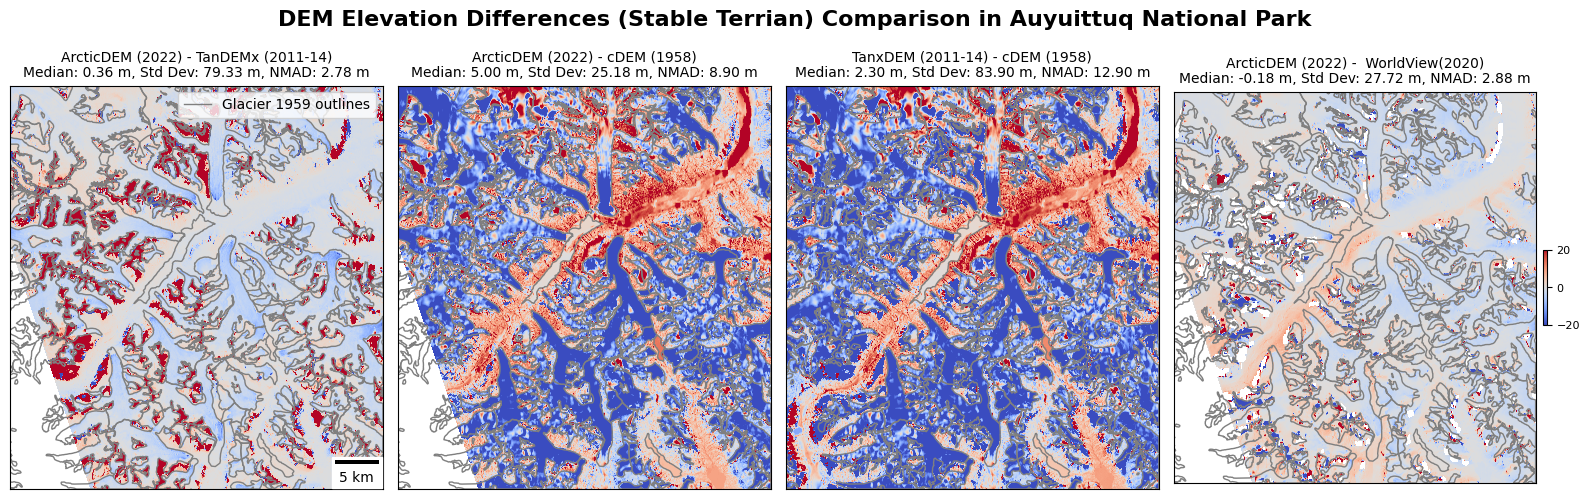

In [17]:
# Plotting the differences side-by-side
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)

# Define a more distinct colormap for elevation differences
cmap = plt.get_cmap('coolwarm')

# Plot the DEM difference images with extent and add the clipped glacier outline
for i, (diff_data, median, std_dev, nmad, title, ax_im) in enumerate([
    (diff_arctic_tanx, median_arctic_tanx, std_arctic_tanx, nmad_arctic_tanx, "ArcticDEM (2022) - TanDEMx (2011-14)", axes[0]),
    (diff_arctic_cdem, median_arctic_cdem, std_arctic_cdem, nmad_arctic_cdem, "ArcticDEM (2022) - cDEM (1958)", axes[1]),
    (diff_tanx_cdem, median_tanx_cdem, std_tanx_cdem, nmad_tanx_cdem, "TanxDEM (2011-14) - cDEM (1958)", axes[2]),
    (diff_arctic_worldview, median_arctic_worldview, std_arctic_worldview, nmad_arctic_worldview, "ArcticDEM (2022) -  WorldView(2020)", axes[3]),
]):
    # Plot DEM difference
    im = ax_im.imshow(diff_data, cmap=cmap, vmin=-20, vmax=20, extent=extent)
    ax_im.set_title(f"{title}\nMedian: {median:.2f} m, Std Dev: {std_dev:.2f} m, NMAD: {nmad:.2f} m", fontsize=10)
    glacier_outline_clipped.plot(ax=ax_im, edgecolor="tab:gray", linewidth=1, facecolor="none", zorder=2)
    if i == 0:
        ax_im.plot([], [], color='tab:gray', linewidth=1, label='Glacier 1959 outlines')
    
    if i == 0:
        scalebar = ScaleBar(1, location='lower right', length_fraction=0.2, units="m", scale_loc="bottom")
        ax_im.add_artist(scalebar)

# Add a colorbar to the right of the entire figure
cbar = fig.colorbar(im, ax=axes[3], fraction=0.01, pad=0.02, location='right') 
cbar.ax.tick_params(labelsize=8)

# Add a main title with location
fig.suptitle("DEM Elevation Differences (Stable Terrian) Comparison in Auyuittuq National Park", 
             fontsize=16, fontweight='bold', y=1.02)

# Adding the legend for glacier outlines
axes[0].legend()

# Adding gridlines for better interpretation
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()